# Expedia Hotel Recommendations


Planning a vacation or weekend getaway often comes with the challenge of choosing the perfect hotel. With countless options available, how do you ensure that a hotel aligns with your personal preferences—whether it's the comfort of a well-known chain or the excitement of a boutique hotel with unique amenities? For platforms like Expedia, delivering tailored recommendations is critical to enhancing user experience, especially with millions of travelers visiting their site each month.

This project solves the challenge of building a machine learning model to predict a user’s likelihood of booking one of 100 different hotel groups. I use Expedia's customer data to move beyond simple search filters to create a personalized recommendation system. The goal is to provide contextually relevant hotel suggestions for users, enhancing both user satisfaction and platform engagement.

## Data Description
Expedia has shared detailed records of how customers interact with their platform. These logs include: Search queries: What the user is searching for (e.g., destination, dates, preferences); Interactions with search results: Whether the user clicked on a hotel, booked it, or just browsed; Search context: Additional details, such as whether the search included a travel package (e.g., flight + hotel).

Expedia uses in-house algorithms to group hotels into clusters, which act as identifiers for types of hotels. This clustering helps in two ways:
- Similarity-based grouping: Hotels are grouped based on shared characteristics like: Historical prices, Customer star ratings, Location attributes (e.g., proximity to the city center).
- Handling outliers: Clustering avoids issues with hotels that lack sufficient historical data (e.g., newly listed hotels).
These clusters are useful because they allow the recommendation model to predict broader categories of hotels that users are likely to book, rather than specific individual hotels.

The goal of the project is to:

1/ Use the provided user interaction data (search attributes, behaviors, and context).
2/ Build a model to predict the hotel cluster (group) that a user will book for a given search or interaction event.

This prediction can enhance Expedia’s recommendation engine, helping the platform offer personalized and contextually relevant hotel suggestions, improving user satisfaction and conversion rates.


## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Reading Datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path_train = '/content/drive/My Drive/blogs/expedia-hotel-recommendation/train.csv'
file_path_test = '/content/drive/My Drive/blogs/expedia-hotel-recommendation/test.csv'

In [4]:
train=pd.read_csv(file_path_train, nrows=100000)
test=pd.read_csv(file_path_test, nrows=100000)

The Dataset contains 37 million logs of customer behaviour, to avoid hang and lagging of system I have selected 100000 logs and entries from each of the dataset i.e train and test dataset.

In [26]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [27]:
train.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

In [28]:
test.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


All the dates in test.csv are 1 year later than the dates in train.csv .The testing set contains dates from 2015 ,and the training set contains dates from 2013 and 2014.

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  100000 non-null  object 
 1   site_name                  100000 non-null  int64  
 2   posa_continent             100000 non-null  int64  
 3   user_location_country      100000 non-null  int64  
 4   user_location_region       100000 non-null  int64  
 5   user_location_city         100000 non-null  int64  
 6   orig_destination_distance  63078 non-null   float64
 7   user_id                    100000 non-null  int64  
 8   is_mobile                  100000 non-null  int64  
 9   is_package                 100000 non-null  int64  
 10  channel                    100000 non-null  int64  
 11  srch_ci                    99929 non-null   object 
 12  srch_co                    99929 non-null   object 
 13  srch_adults_cnt            100

In [30]:
test.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


## Description

In [5]:
train = pd.read_csv(file_path_train, parse_dates=['date_time'] ,sep=',',nrows=200000)

In [33]:
train.shape

(200000, 24)

In [34]:
train.dtypes

,0
date_time,datetime64[ns]
site_name,int64
posa_continent,int64
user_location_country,int64
user_location_region,int64
user_location_city,int64
orig_destination_distance,float64
user_id,int64
is_mobile,int64
is_package,int64


## What we're predicting?
The goal of the project is to predict the hotel cluster for the hotel a user will book based on their search and interaction attributes. The predicted cluster represents the type of hotel that best matches the user’s preferences and behavior.Expedia uses in-house clustering algorithms to assign each hotel to one of 100 predefined clusters. Instead of predicting the specific hotel a user will book (which could lead to overfitting due to data sparsity), the model predicts the cluster to which the booked hotel belongs. A user event refers to an interaction a user has with the Expedia platform. For example: Searching for hotels in a specific city for certain travel dates; Viewing hotel search results; Clicking on a particular hotel listing; Booking a hotel (or deciding not to book). Each user event generates data, such as: Search parameters: Destination, check-in/check-out dates, number of guests; User attributes: Location, device type, loyalty program membership; Interaction details: Whether the user clicked or booked a hotel; Additional context: Whether the search included a travel package (e.g., flight + hotel).


## Missing Values

In [35]:
train.isnull().sum()

,0
date_time,0
site_name,0
posa_continent,0
user_location_country,0
user_location_region,0
user_location_city,0
orig_destination_distance,69637
user_id,0
is_mobile,0
is_package,0


In [6]:
total=train.isnull().sum().sort_values(ascending=False)
percent=(train.isnull().sum()/train['hotel_cluster'].count()).sort_values(ascending=False)
missing_data=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
orig_destination_distance,69637,0.348185
srch_ci,177,0.000885
srch_co,177,0.000885
date_time,0,0.000000
user_location_country,0,0.000000
user_location_region,0,0.000000
posa_continent,0,0.000000
site_name,0,0.000000
user_id,0,0.000000
user_location_city,0,0.000000


 Remove the missing values & impute values for orig_destination_distance

In [7]:
train['orig_destination_distance'].fillna(train['orig_destination_distance'].mean(), inplace=True)
test['orig_destination_distance'].fillna(test['orig_destination_distance'].mean(), inplace=True)

<ipython-input-7-6a8338193971>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['orig_destination_distance'].fillna(train['orig_destination_distance'].mean(), inplace=True)
<ipython-input-7-6a8338193971>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

In [8]:
train.isnull().sum()

,0
date_time,0
site_name,0
posa_continent,0
user_location_country,0
user_location_region,0
user_location_city,0
orig_destination_distance,0
user_id,0
is_mobile,0
is_package,0


In [9]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [10]:
train.shape

(199823, 24)

In [11]:
test.shape

(39999, 22)

## Visualization

### 1. Corelation between the columns

A Heatmap to infer the correlation between different columns with each other and to check if there is any linear correlation between any columns.

In [12]:
numerical_data = train.select_dtypes(include=['number'])  # Select only numerical columns

<Axes: >

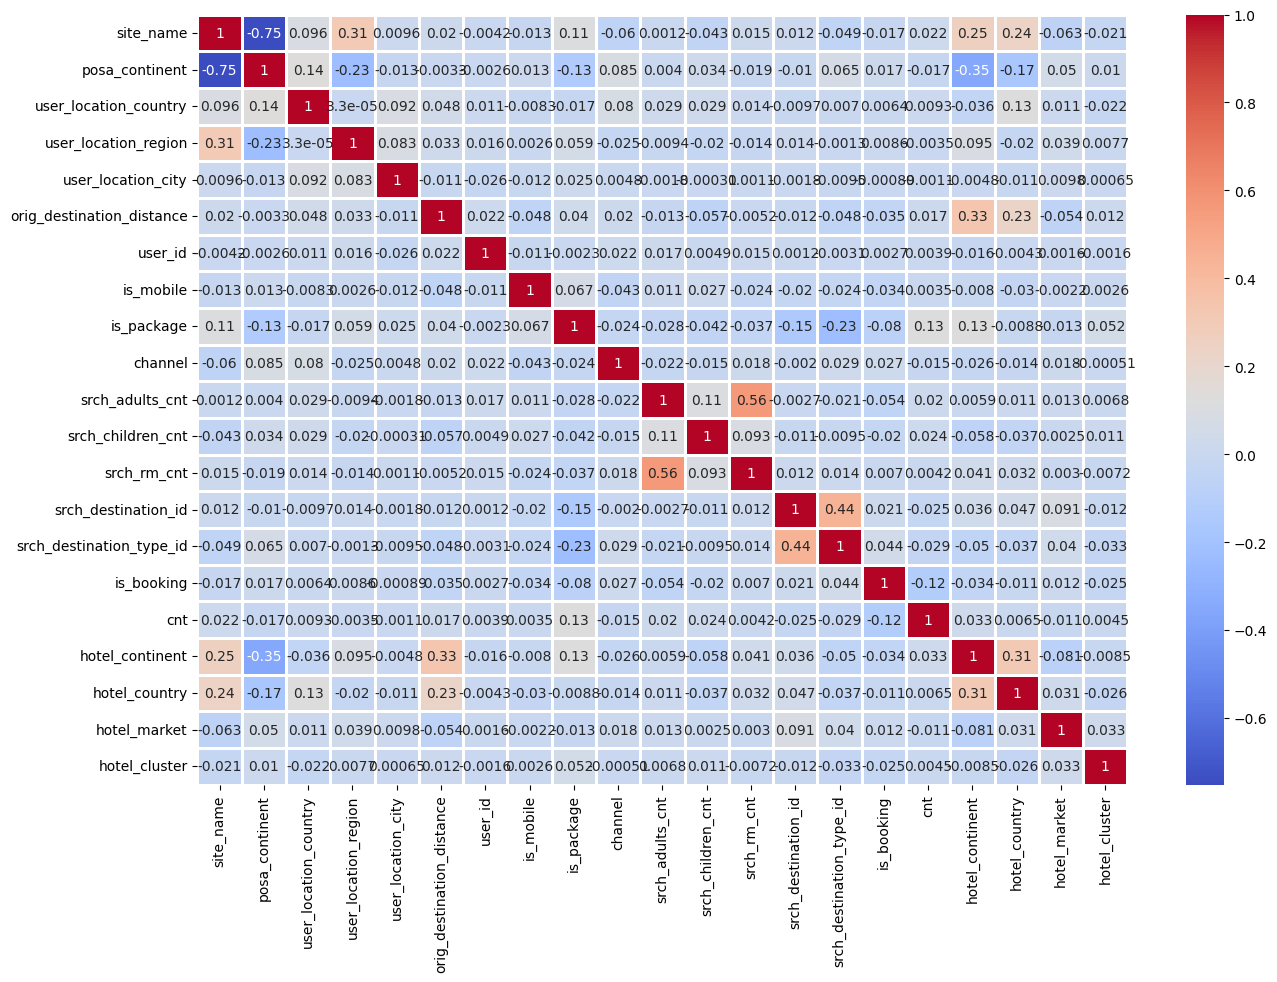

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(numerical_data.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)

**This tell us that no column correlate linearly with any other column in the dataset.**

### 2. Frequency of bookings through mobile

<Axes: xlabel='is_mobile', ylabel='count'>

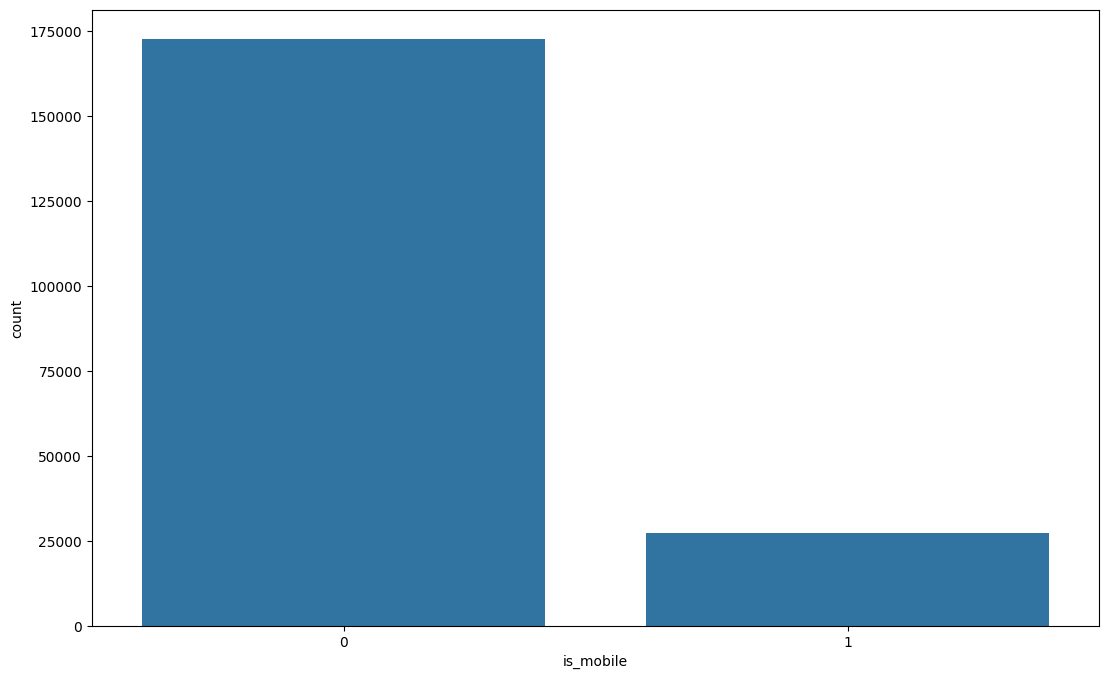

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='is_mobile',data=train, order=[0,1],ax=ax)

**Customers book their hotels from Expedia Website rather than mobile. So we can suggest Expedia to make more interactive, easy to use website so customers can easily book their hotels**

### 3. Frequency of bookings with total package(i.e with travel)

<Axes: xlabel='is_package', ylabel='count'>

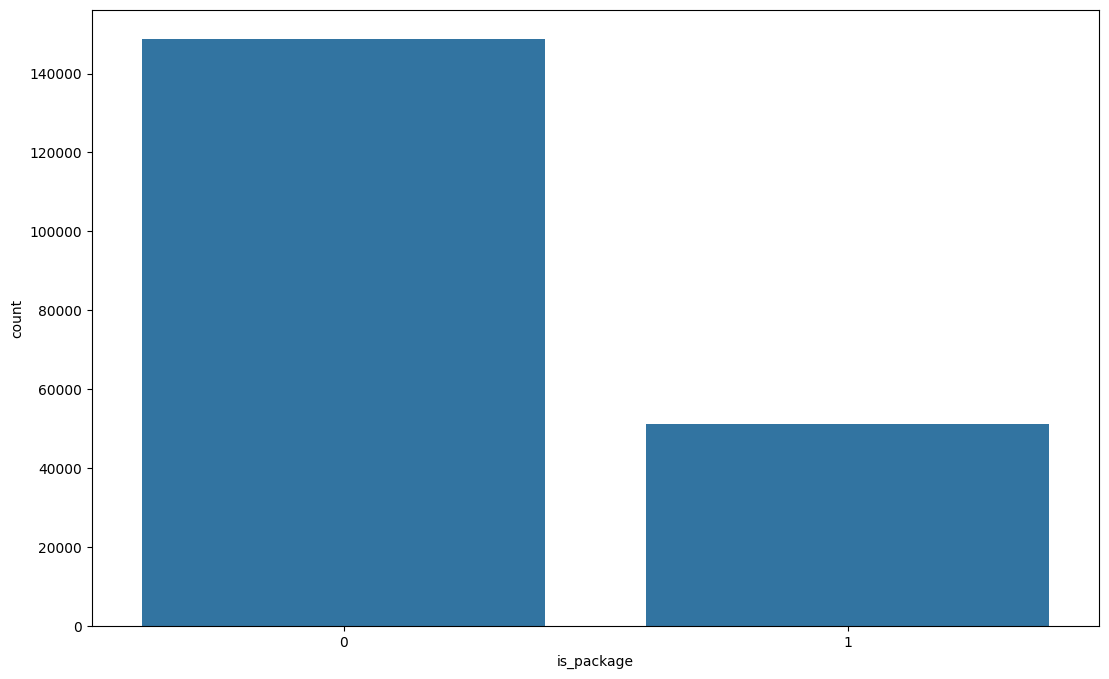

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='is_package',data=train, order=[0,1], ax=ax)

Relatively fewer customers book hotels as part of a total package, which includes additional travel services such as flights or car rentals. This may stem from various factors, including perceived high costs, limited hotel choices, and customer preferences for flexibility.

### 4. Frequency of Continent site used for booking

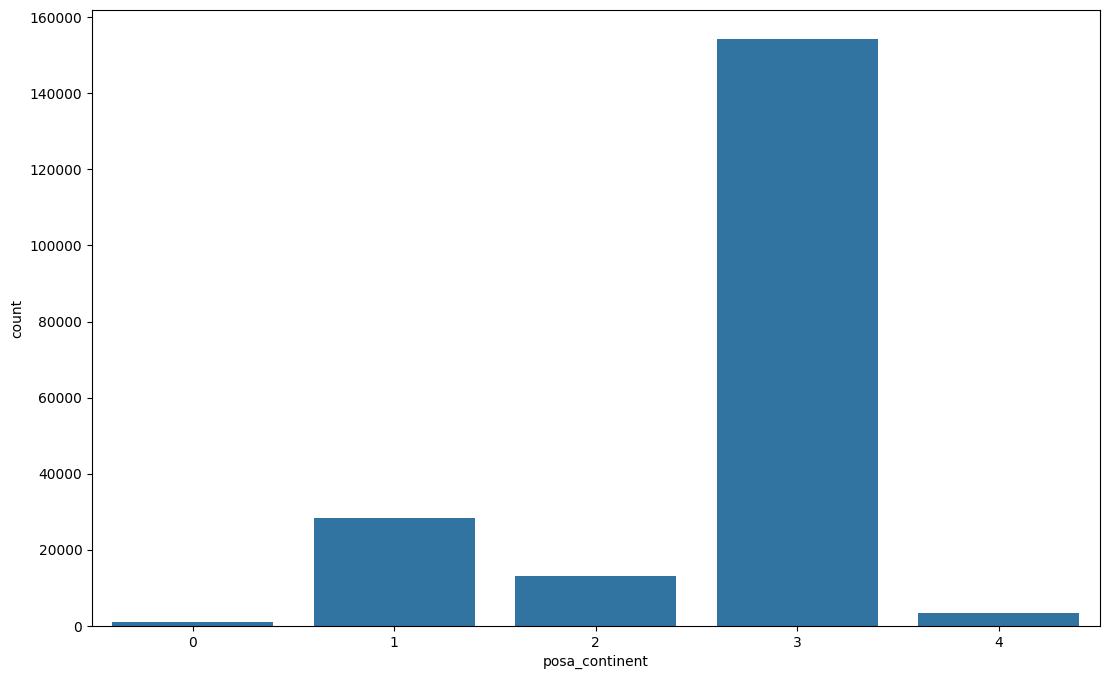

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='posa_continent', data=train, order=[0, 1, 2, 3, 4], ax=ax)
plt.show()

Most bookings are made by users from continent 3. Maybe users from continent 3 may have greater disposable income, allowing them to travel more frequently and book hotels through Expedia. Or expedia may already have a strong presence in continent 3, with better marketing, partnerships, and localized offerings. Or users in this region might trust Expedia more due to better user experience, reputation, or familiarity with the platform.

### 5. Which continent has the most number of hotels?

<Axes: xlabel='hotel_continent', ylabel='count'>

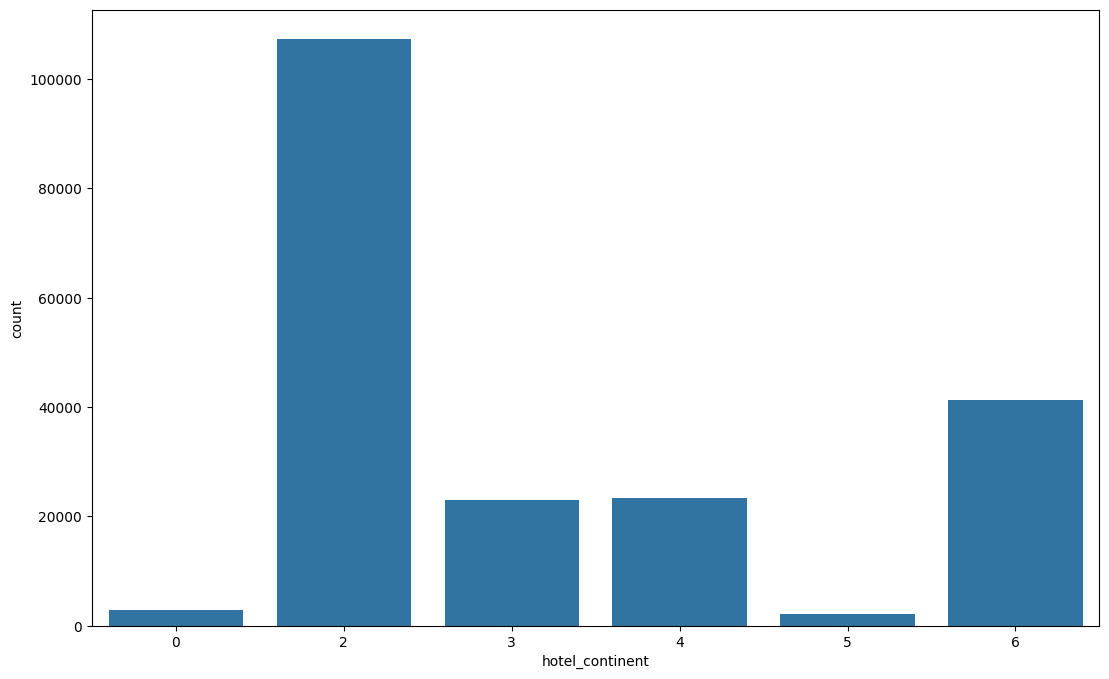

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='hotel_continent', data=train,order=[0,2,3,4,5,6],ax=ax)

### 6. Putting the two above together

<Axes: xlabel='hotel_continent', ylabel='count'>

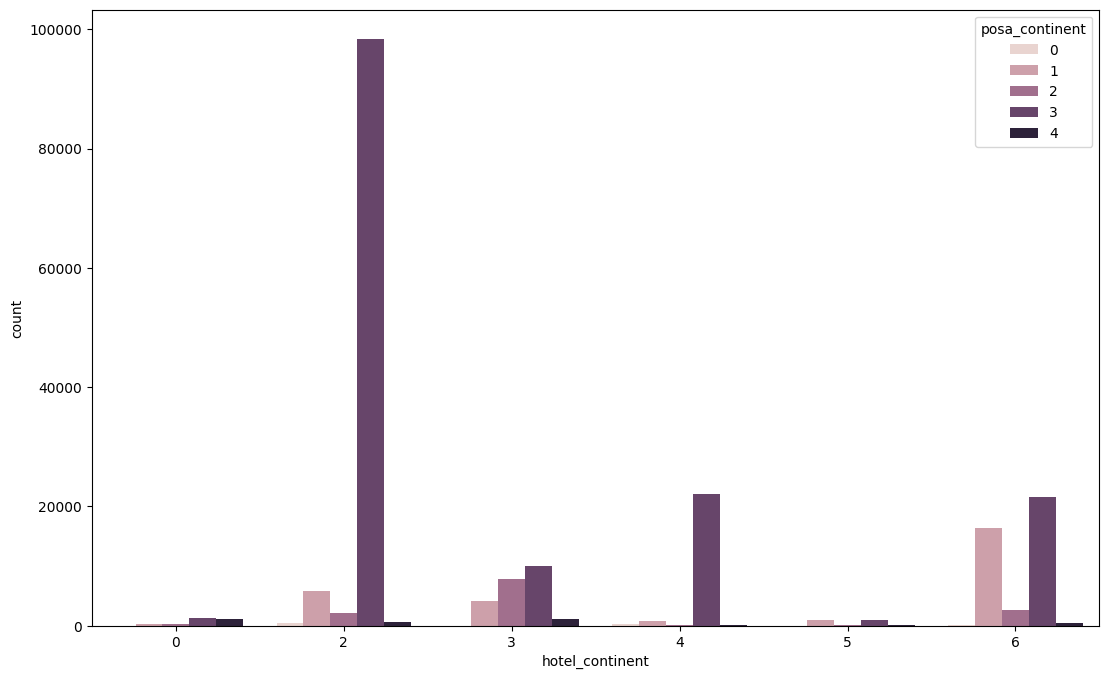

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='hotel_continent', hue='posa_continent', data=train)

## Let us look at data specifically where customers have made a booking

In [13]:
bookings=train[train["is_booking"] == 1]

### 7. Which are the countries where the customer travel from?

<Axes: xlabel='user_location_country', ylabel='count'>

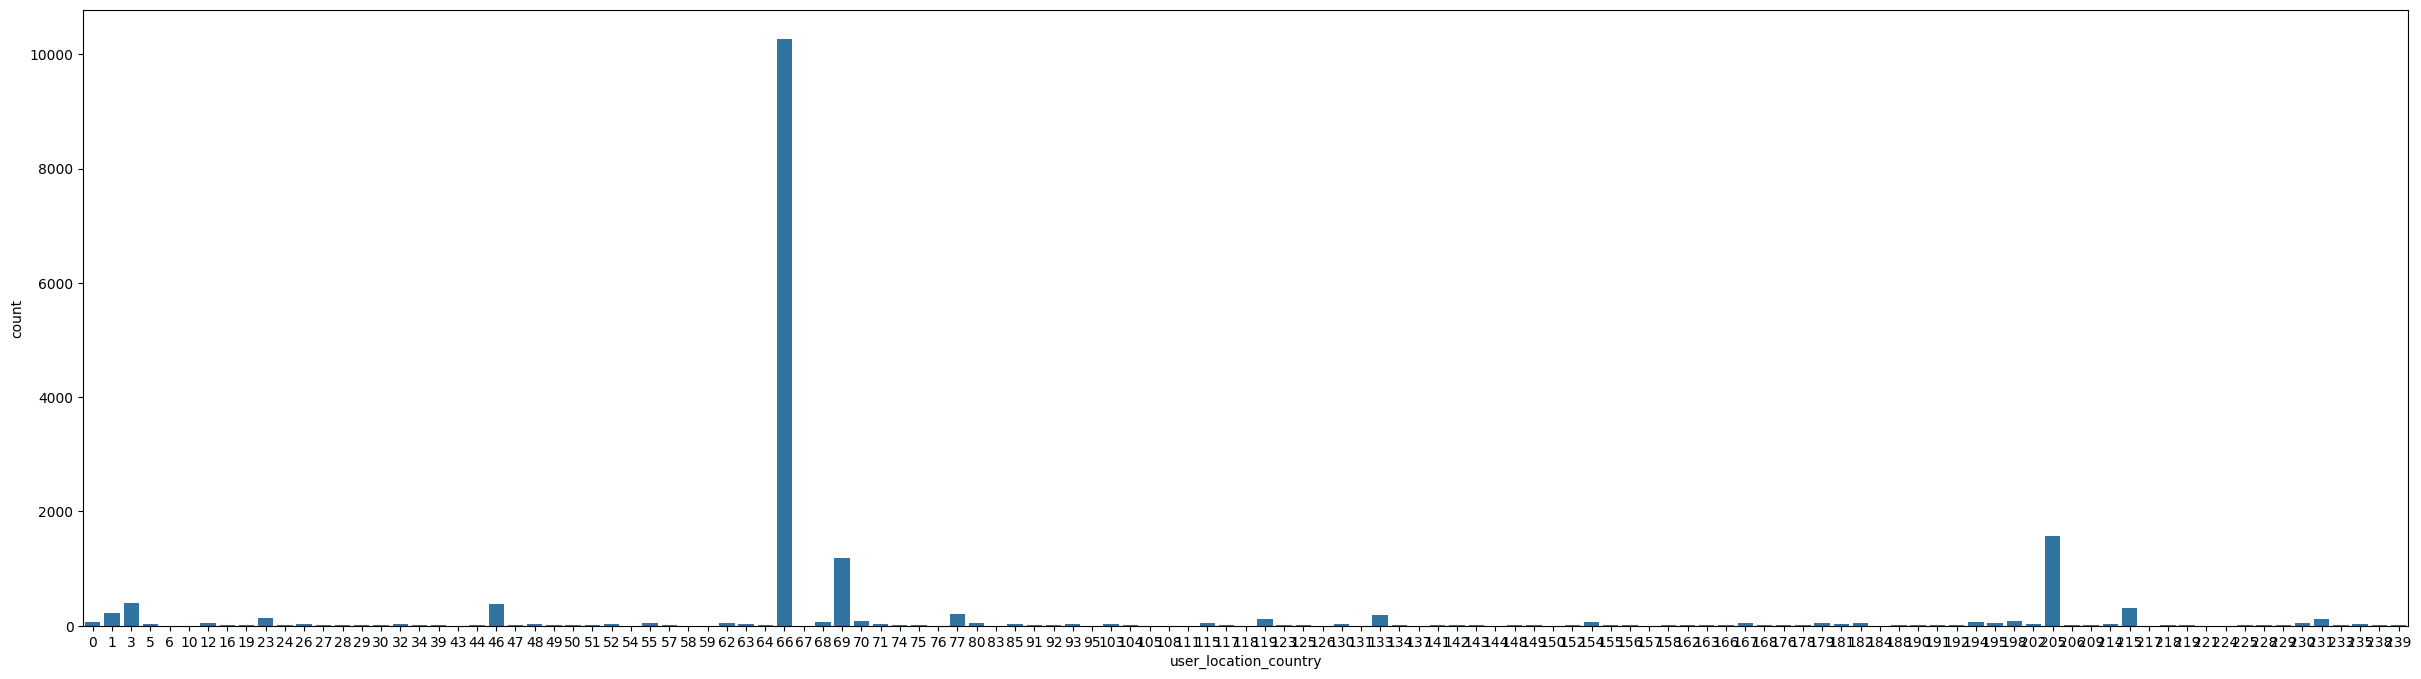

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(30,8)
sns.countplot(x='user_location_country',data=bookings.sort_values(by=['user_location_country']))

**Most customers booking through Expedia are traveling from country 66. They can reward frequent customers in high-performing countries, investigate and address barriers in low-performing countries, such as pricing issues, lack of hotel variety, or limited awareness.**

### 8. Which are the countries where most of customers travel to?

<Axes: xlabel='hotel_country', ylabel='count'>

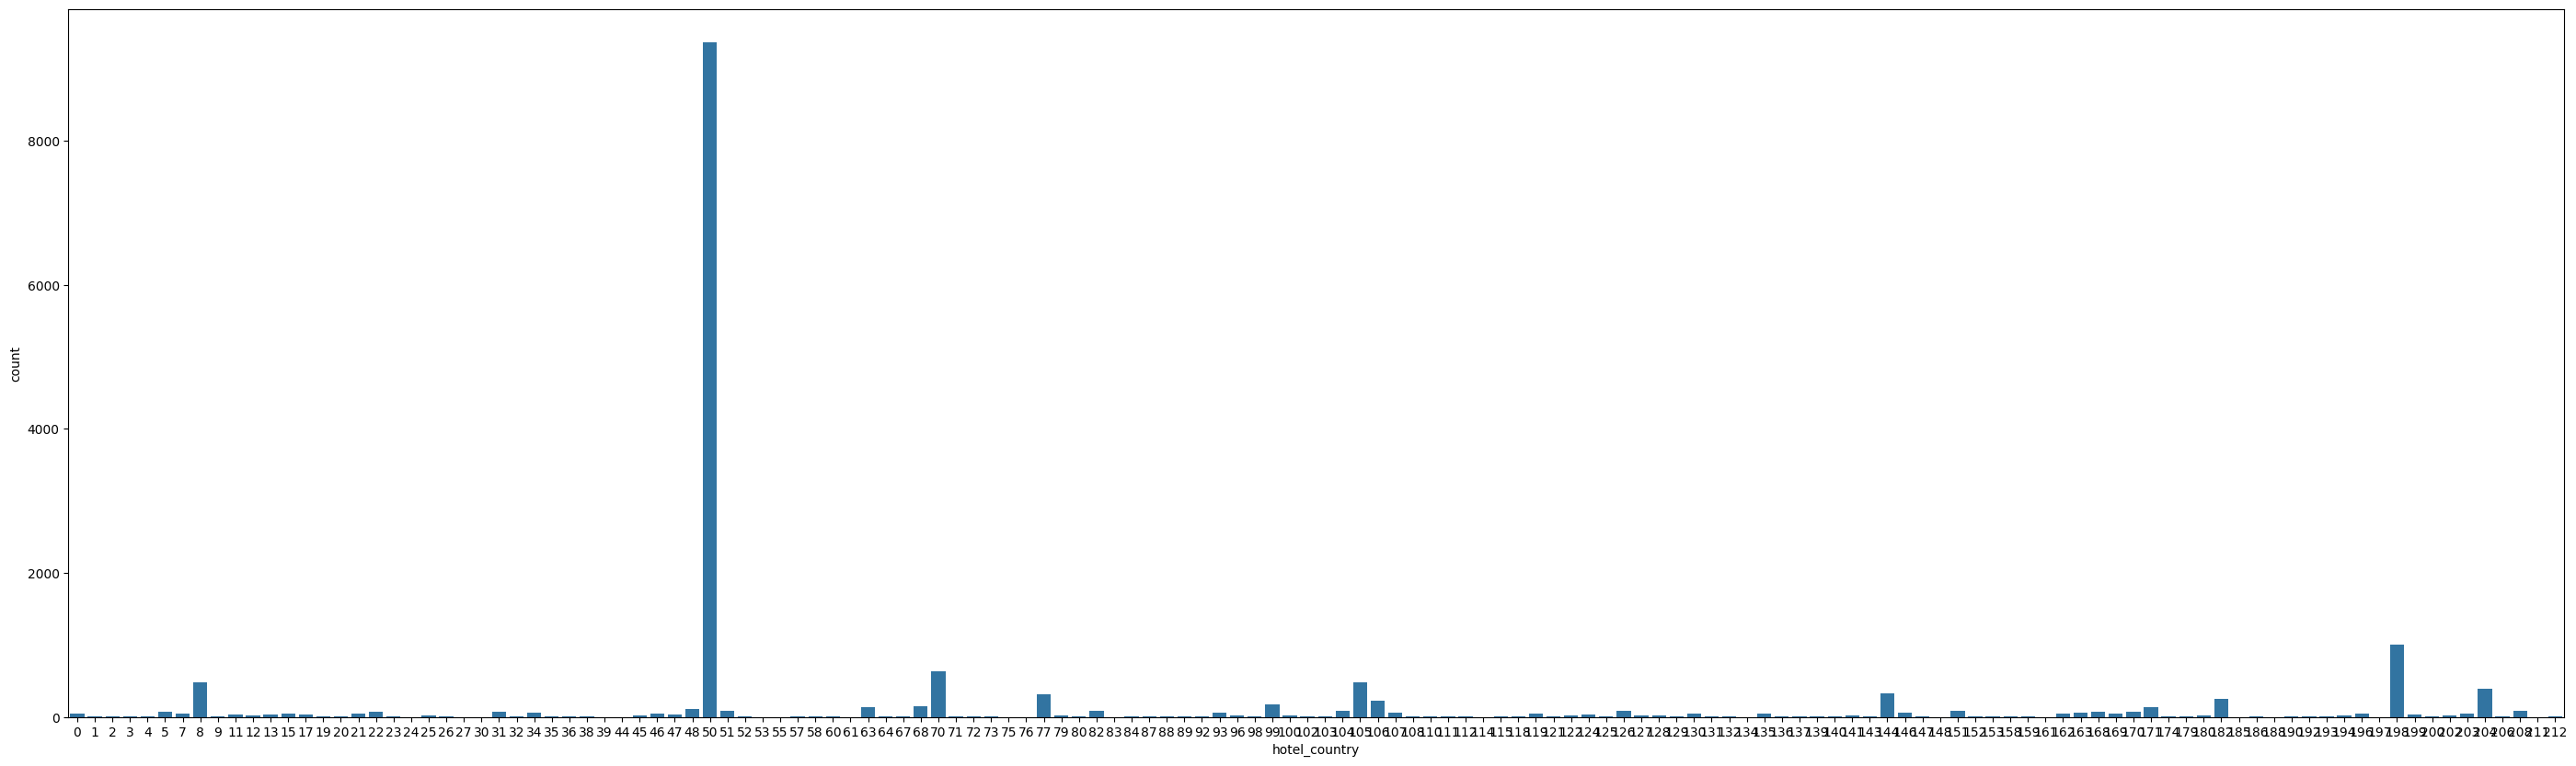

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(35,10)
sns.countplot(x='hotel_country',data=bookings.sort_values(by=['hotel_country']))

**If customers are travelling to 50th country the most, we can give an insight to Expedia to give more recommendations of different hotel with different range of prices, with different facilities, with different locations i.e hotels in every region, every city of the 50th country.**

### 9. How many people by continent are booking from mobile?

<Axes: xlabel='posa_continent', ylabel='count'>

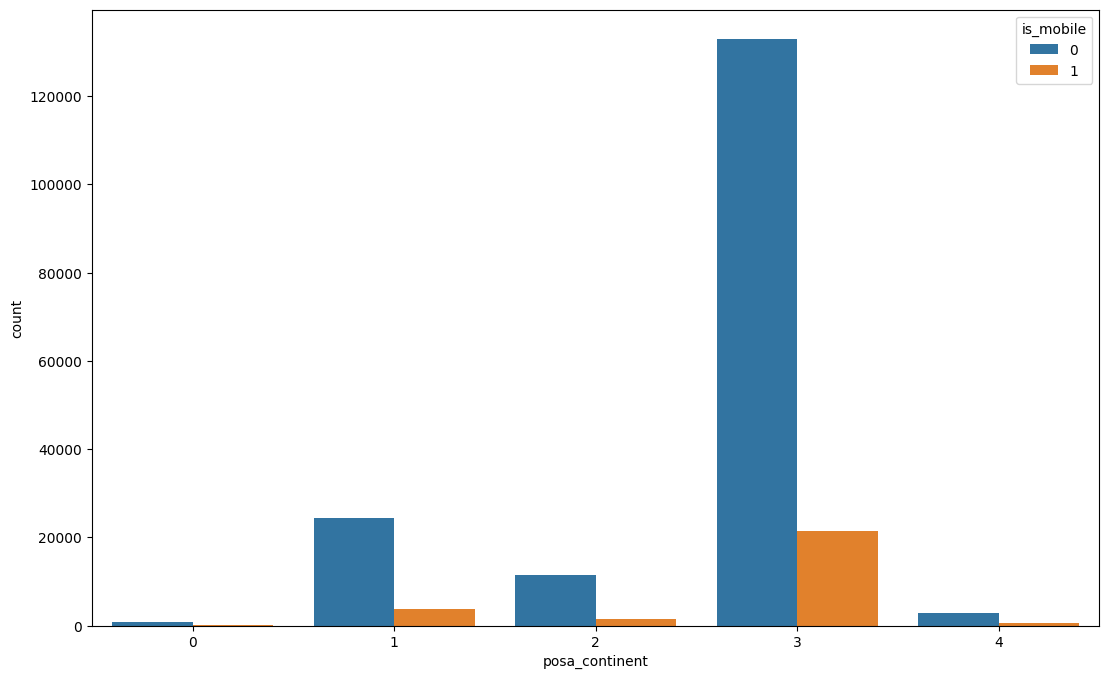

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='posa_continent', hue='is_mobile', data = train)

**This graph we can use to give an insight to Expedia that to improve desktop website interface and to make it more interactive, easy payment and website doesn't crash when lot of customer tries to book their ticket rather than on mobile interface**

### 10. How many people by country are booking from mobile?

<Axes: xlabel='user_location_country', ylabel='count'>

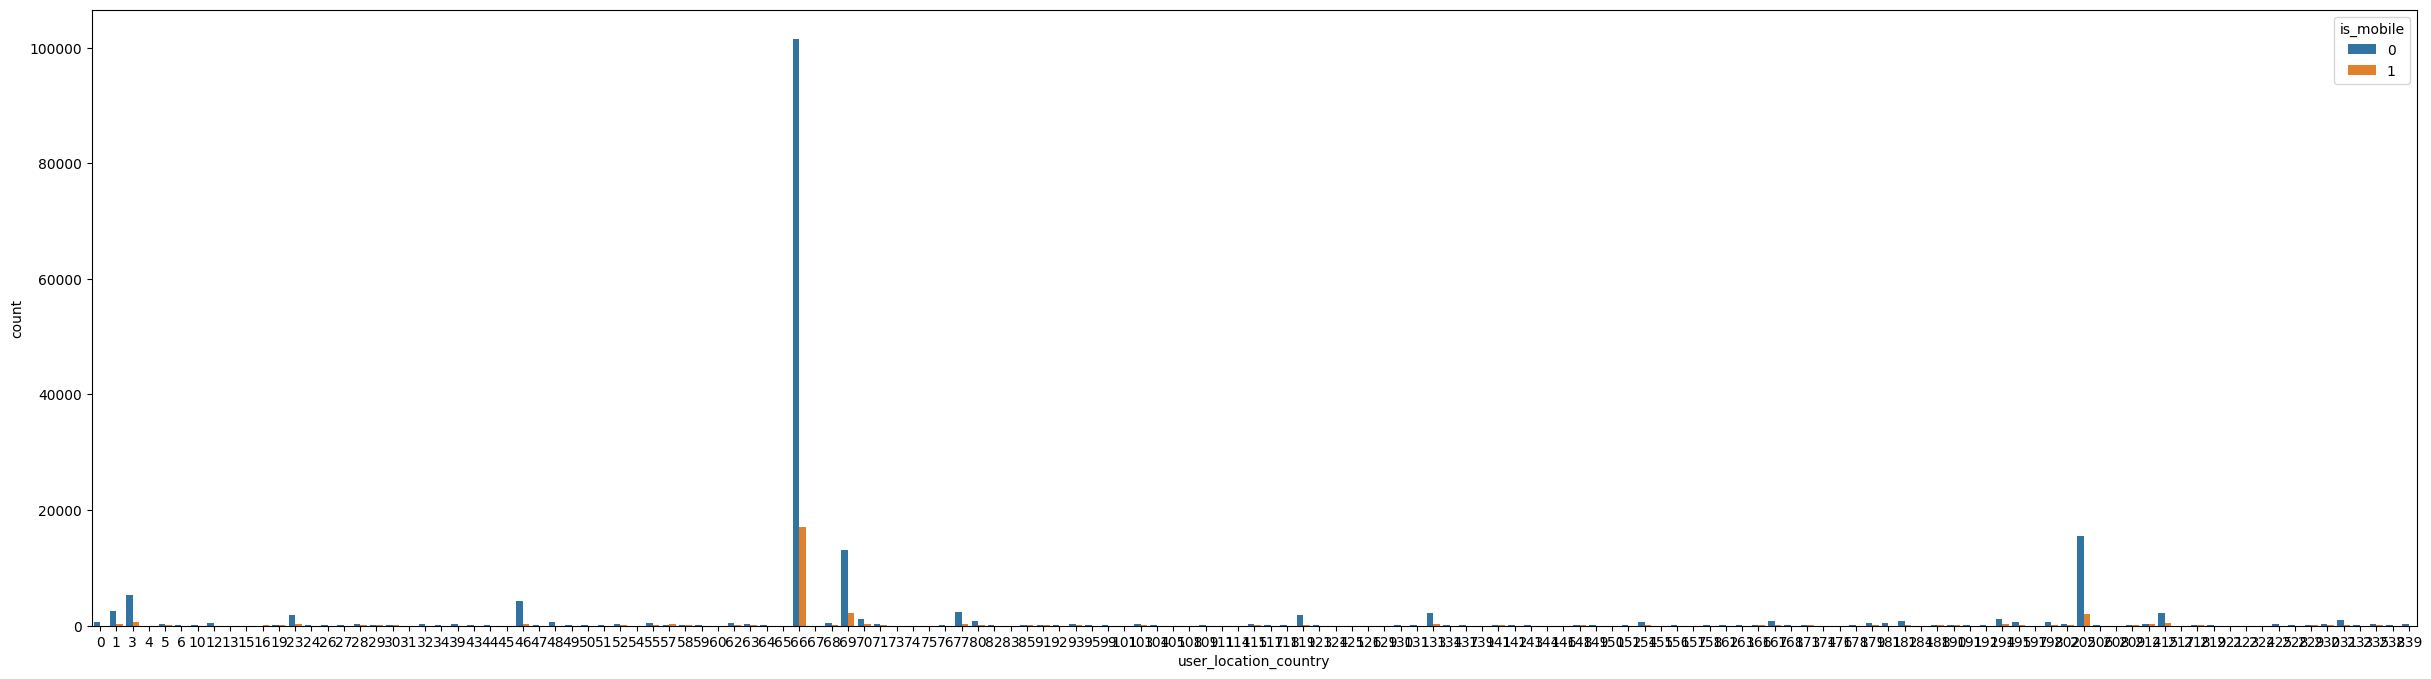

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 8)
sns.countplot(x='user_location_country', hue='is_mobile', data = train)

### 11. Frequency for each hotel Clusters

<Axes: xlabel='hotel_cluster'>

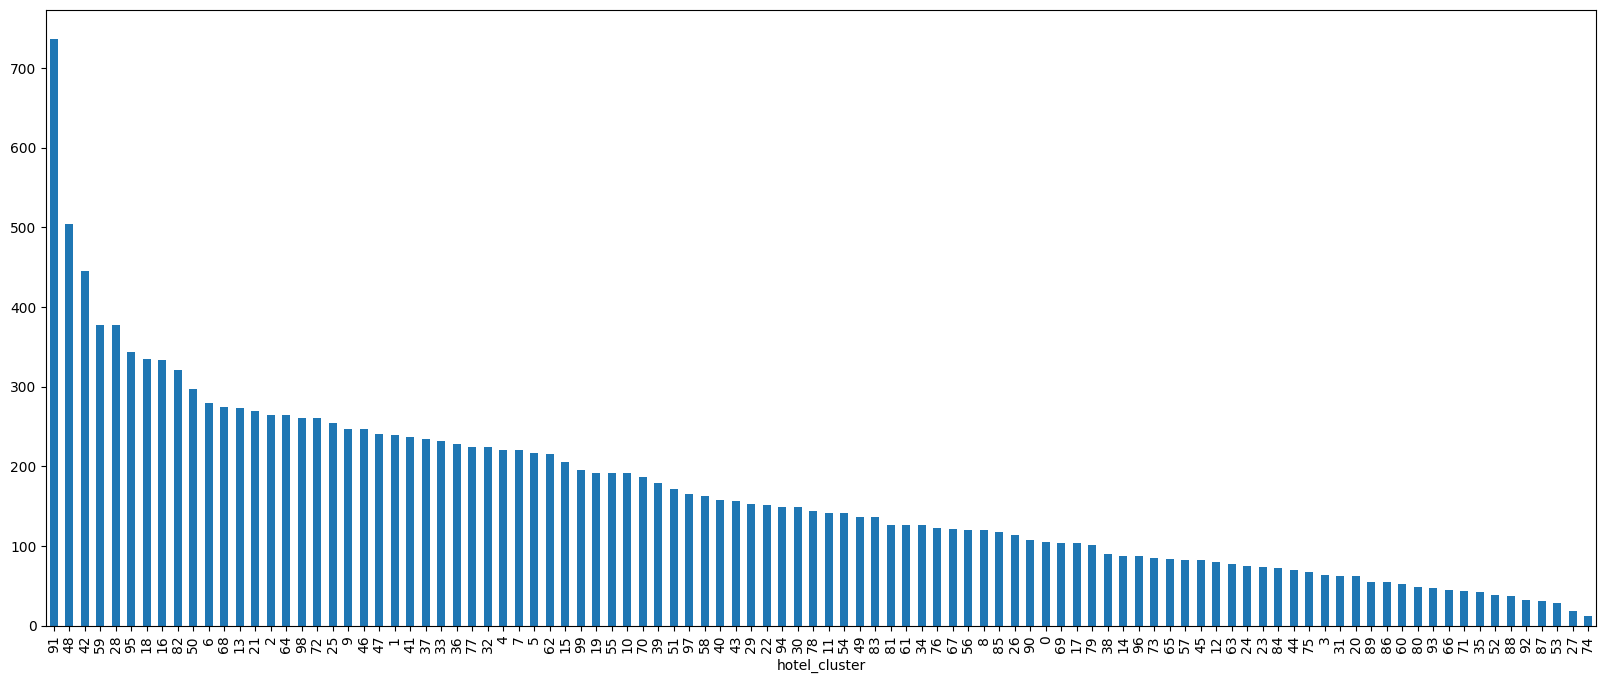

In [60]:
bookings['hotel_cluster'].value_counts().plot(kind='bar',figsize=(20,8))

Hotel cluster 91 is the most booked hotel

### 12. What's the most impactful channel?

<Axes: xlabel='channel', ylabel='count'>

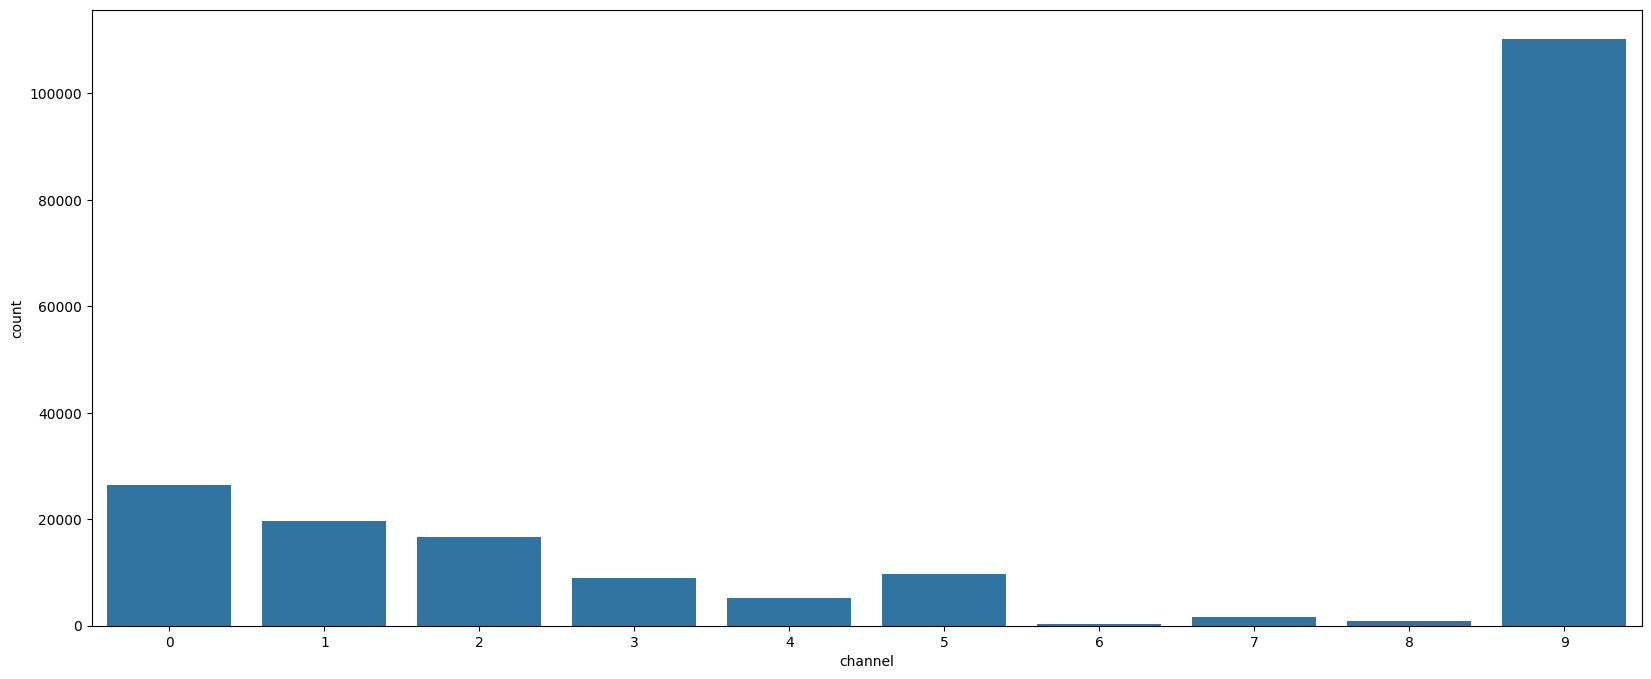

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x='channel', order=list(range(0,10)), data=train)

Marketing channel 9 is the most successful

## Feature Engineering

**We can find out the duration of stay of the customers by subtracting the date of check-in to check-out to help Expedia to categorize the hotels like "Long Trips" where customers book their hotels for long period of time or "Short Trips" where customers book their hotels for short period of time. This could help to recommend other customers when those customers choose the same search parameters like "Long Trips" and "Short Trips".**

In [14]:
def convert_date_into_days(df):
    """
    Adds new date-related features to the DataFrame:
    - Converts 'srch_ci' and 'srch_co' to datetime objects.
    - Calculates 'stay_duration' (days between check-in and check-out).
    - Calculates 'no_of_prior_days_booking' (days between booking date and check-in).
    - Extracts day, month, and year from the check-in date.

    Args:
        df (pd.DataFrame): DataFrame containing 'srch_ci', 'srch_co', and 'date_time' columns.

    Returns:
        pd.DataFrame: DataFrame with new datetime-related features added.
    """
    # Convert to datetime
    df['srch_ci'] = pd.to_datetime(df['srch_ci'], infer_datetime_format=True, errors='coerce')
    df['srch_co'] = pd.to_datetime(df['srch_co'], infer_datetime_format=True, errors='coerce')
    df['date_time'] = pd.to_datetime(df['date_time'], infer_datetime_format=True, errors='coerce')

    # Calculate stay duration and prior booking days
    df['stay_duration'] = (df['srch_co'] - df['srch_ci']).dt.days
    df['no_of_prior_days_booking'] = (df['srch_ci'] - df['date_time']).dt.days

    # Handle missing or invalid values
    df['stay_duration'] = df['stay_duration'].fillna(0)
    df['no_of_prior_days_booking'] = df['no_of_prior_days_booking'].fillna(0)
    df = df[df['stay_duration'] > 0]
    df = df[df['no_of_prior_days_booking'] >= 0]

    # Extract day, month, and year from check-in date
    df['Cin_day'] = df['srch_ci'].dt.day
    df['Cin_month'] = df['srch_ci'].dt.month
    df['Cin_year'] = df['srch_ci'].dt.year

    return df


In [15]:
train = convert_date_into_days(train)

<ipython-input-14-14e2161e2444>:16: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['srch_ci'] = pd.to_datetime(df['srch_ci'], infer_datetime_format=True, errors='coerce')
<ipython-input-14-14e2161e2444>:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['srch_co'] = pd.to_datetime(df['srch_co'], infer_datetime_format=True, errors='coerce')
<ipython-input-14-14e2161e2444>:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pd

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193001 entries, 0 to 199999
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date_time                  193001 non-null  datetime64[ns]
 1   site_name                  193001 non-null  int64         
 2   posa_continent             193001 non-null  int64         
 3   user_location_country      193001 non-null  int64         
 4   user_location_region       193001 non-null  int64         
 5   user_location_city         193001 non-null  int64         
 6   orig_destination_distance  193001 non-null  float64       
 7   user_id                    193001 non-null  int64         
 8   is_mobile                  193001 non-null  int64         
 9   is_package                 193001 non-null  int64         
 10  channel                    193001 non-null  int64         
 11  srch_ci                    193001 non-null  datetime64[ns

In [17]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,stay_duration,no_of_prior_days_booking,Cin_day,Cin_month,Cin_year
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,3,2,50,628,1,4,15,27,8,2014
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,1,2,50,628,1,4,17,29,8,2014
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,1,2,50,628,1,4,17,29,8,2014
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,1,2,50,1457,80,5,105,23,11,2014
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,1,2,50,1457,21,5,105,23,11,2014


### 13. How many bookings in each year?

<Axes: xlabel='Cin_year', ylabel='count'>

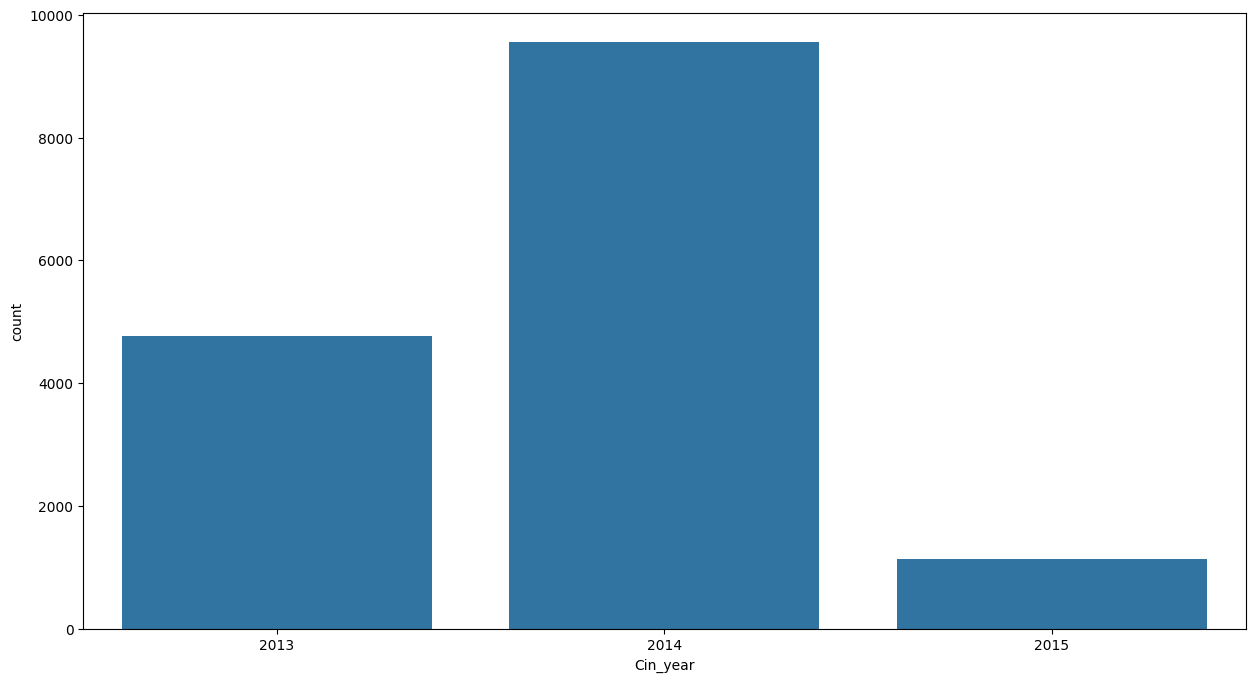

In [70]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.countplot(x='Cin_year',data=train[train['is_booking']==1])

**Bookings by customer in each year. This helps us to understand Expedia business i.e in 2013 was good, then during 2014 Expedia's business was at its peak then in 2015 Expedia's business was at its worst**

### 14. How many bookings in each month?

<Axes: xlabel='Cin_month', ylabel='count'>

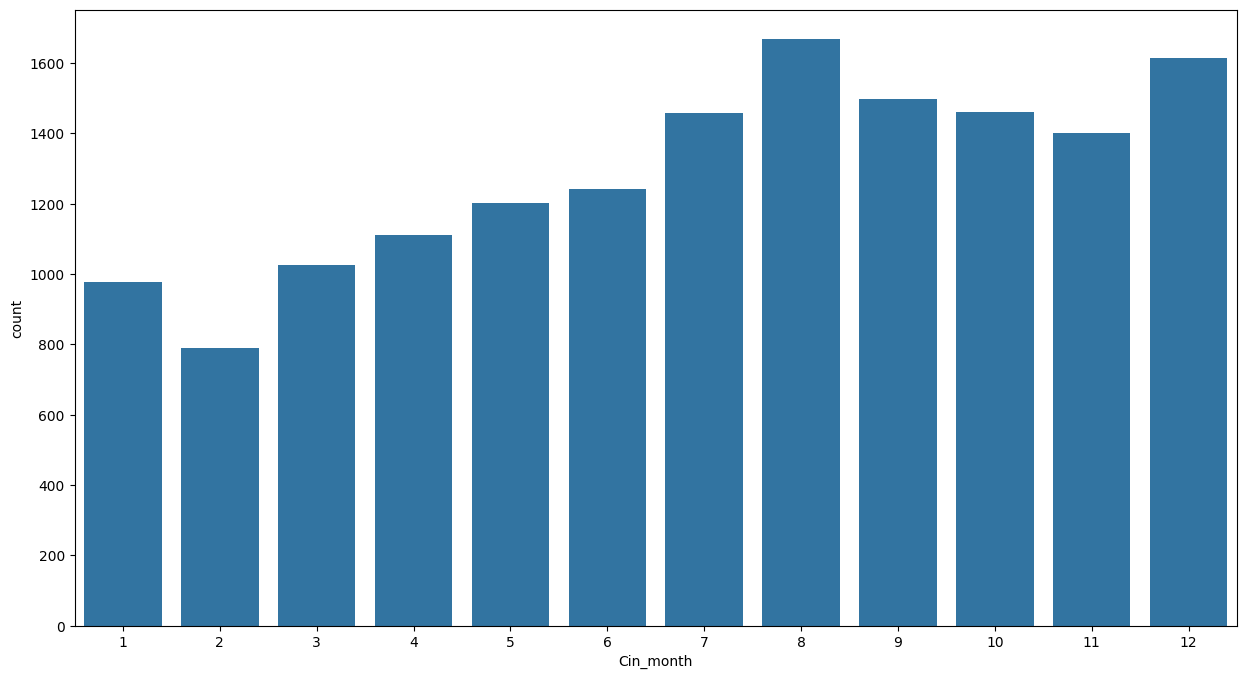

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.countplot(x='Cin_month',data=train[train['is_booking']==1],order=list(range(1,13)))

**This graph tells us about the customer behaviour that is when the customer are more likely to book their hotels and want to travel with their family.**

**According to the graph we can deduce that during 8th month which is August, customers book hotels the most.**

### 15. How many bookings in each day?

<Axes: xlabel='Cin_day', ylabel='count'>

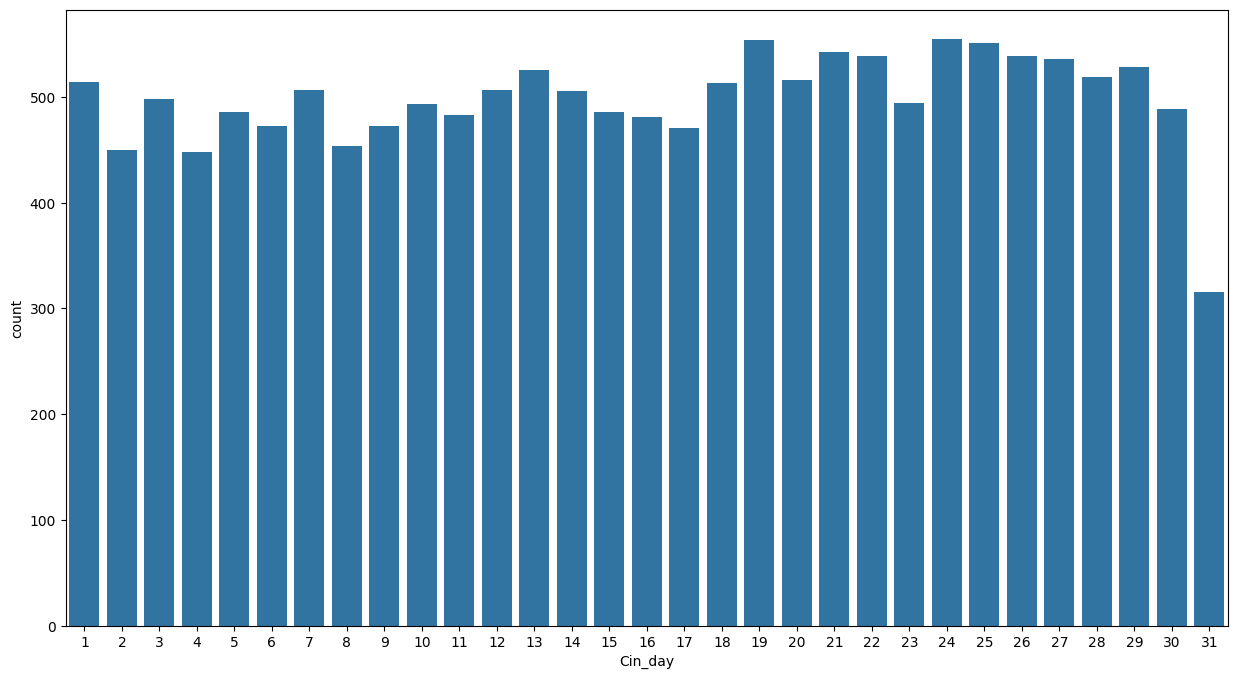

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.countplot(x='Cin_day',data=train[train['is_booking']==1])

**According to the graph we can deduce that on 1st day of any month customers are likely more to travel and book hotels.**

**On 1st of each month customers get their salary and at that point they plan their trip**

### 16. Total Booking over the years

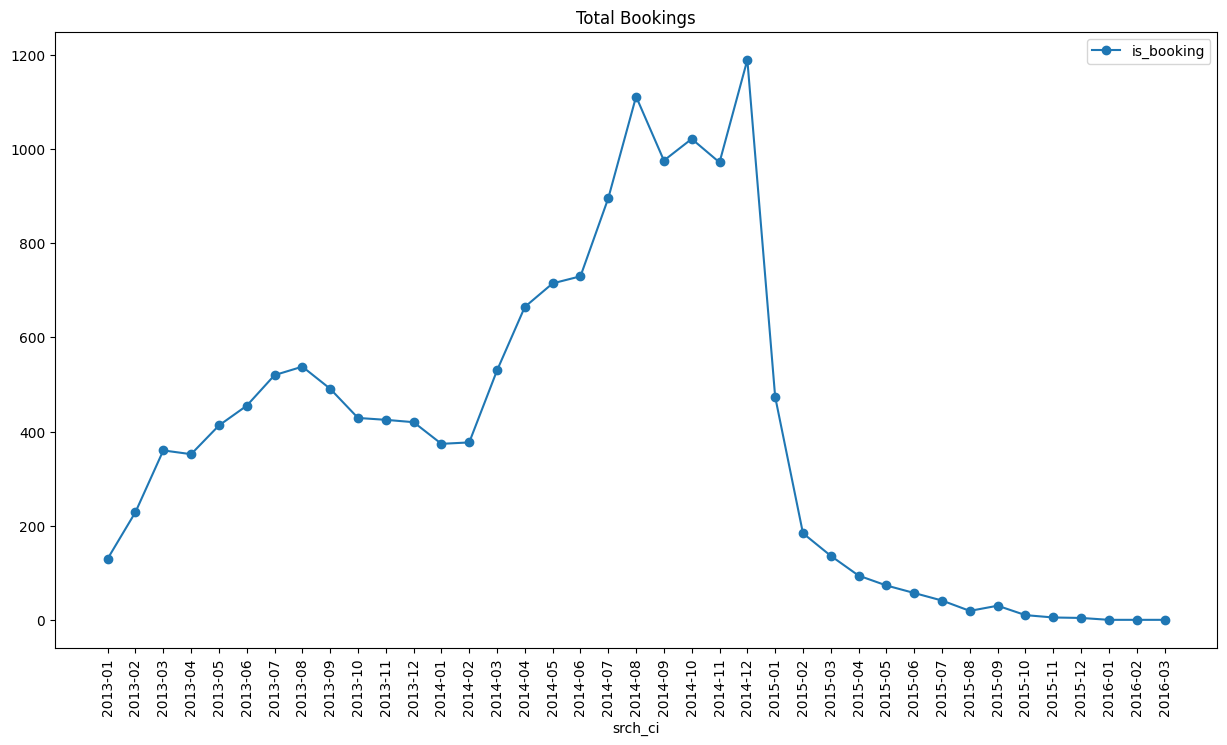

In [18]:
no_of_bookings=train['srch_ci'].apply(lambda x: (str(x)[:7]) if x == x else np.nan)
date_bookings  = train.groupby(no_of_bookings)["is_booking"].sum()
ax1 = date_bookings.plot(legend=True,marker='o',title="Total Bookings", figsize=(15,8))
ax1.set_xticks(range(len(date_bookings)))
xlabels = ax1.set_xticklabels(date_bookings.index.tolist(), rotation=90)

### 17. Frequency of stay duration booked by customers

<Axes: xlabel='stay_duration', ylabel='count'>

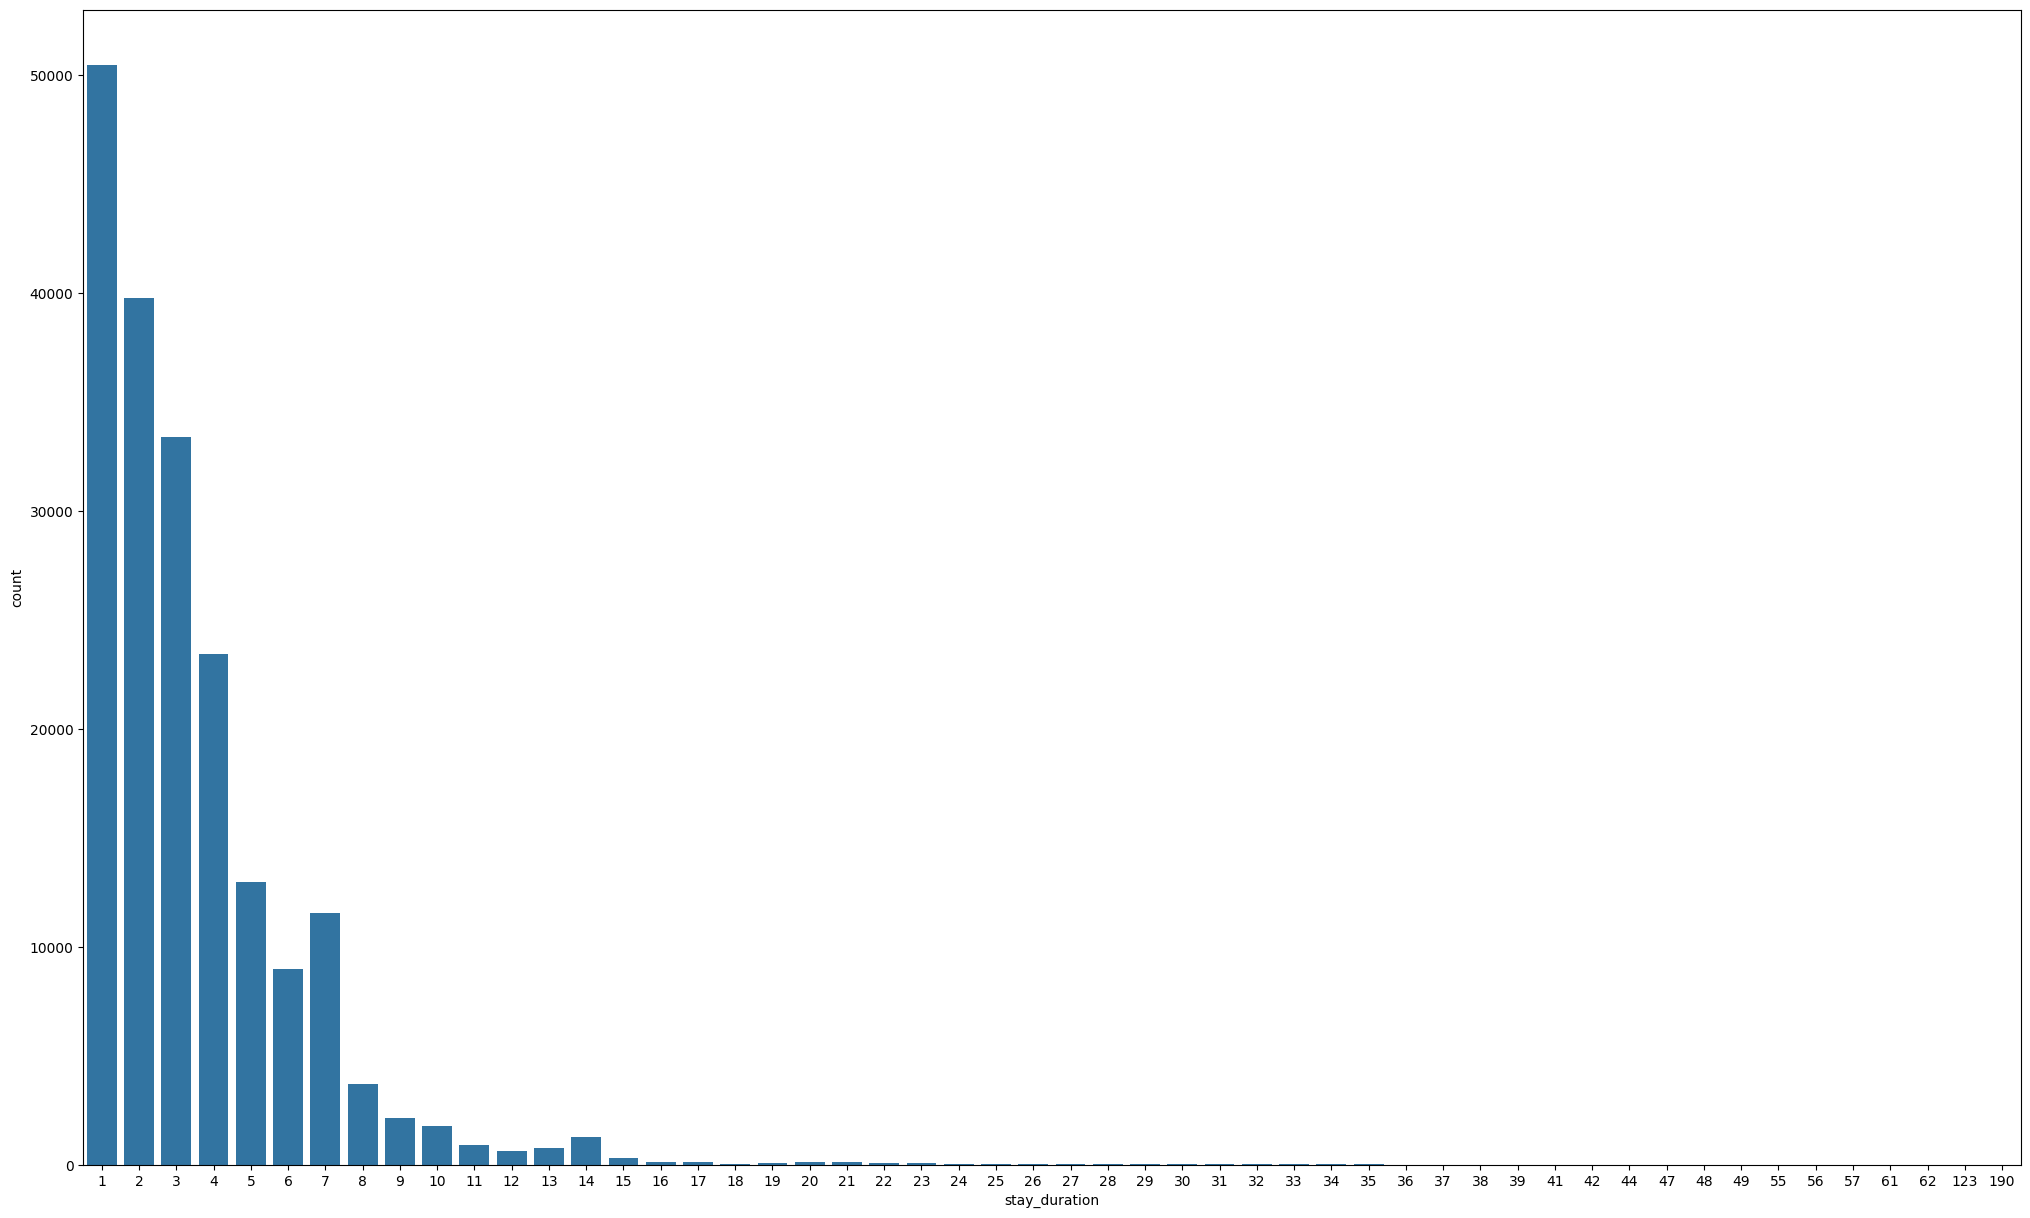

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
sns.countplot(x="stay_duration", data=train)

In [19]:
train['stay_duration'].max()

190

## Data Cleaning

In [20]:
train.corr()["hotel_cluster"]

,hotel_cluster
date_time,0.001078
site_name,-0.022374
posa_continent,0.011046
user_location_country,-0.022260
user_location_region,0.007626
user_location_city,0.000568
orig_destination_distance,0.009409
user_id,-0.002176
is_mobile,0.006387
is_package,0.050130


This tell us that no column correlate linearly with hotel_cluster.

**Removing unnecessary columns**

In [21]:
columns = ['date_time', 'srch_ci', 'srch_co']
train.drop(columns=columns,axis=1,inplace=True)
test.drop(columns=columns,axis=1,inplace=True)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193001 entries, 0 to 199999
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   site_name                  193001 non-null  int64  
 1   posa_continent             193001 non-null  int64  
 2   user_location_country      193001 non-null  int64  
 3   user_location_region       193001 non-null  int64  
 4   user_location_city         193001 non-null  int64  
 5   orig_destination_distance  193001 non-null  float64
 6   user_id                    193001 non-null  int64  
 7   is_mobile                  193001 non-null  int64  
 8   is_package                 193001 non-null  int64  
 9   channel                    193001 non-null  int64  
 10  srch_adults_cnt            193001 non-null  int64  
 11  srch_children_cnt          193001 non-null  int64  
 12  srch_rm_cnt                193001 non-null  int64  
 13  srch_destination_id        193001 

In [23]:
Y = train['hotel_cluster']
X = train.drop(['hotel_cluster'],axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193001 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   site_name                  193001 non-null  int64  
 1   posa_continent             193001 non-null  int64  
 2   user_location_country      193001 non-null  int64  
 3   user_location_region       193001 non-null  int64  
 4   user_location_city         193001 non-null  int64  
 5   orig_destination_distance  193001 non-null  float64
 6   user_id                    193001 non-null  int64  
 7   is_mobile                  193001 non-null  int64  
 8   is_package                 193001 non-null  int64  
 9   channel                    193001 non-null  int64  
 10  srch_adults_cnt            193001 non-null  int64  
 11  srch_children_cnt          193001 non-null  int64  
 12  srch_rm_cnt                193001 non-null  int64  
 13  srch_destination_id        193001 

## Dividing the train dataset into 2 parts

1. Learning Dataset
2. Test Dataset

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=1)
print(len(X_train))
print(len(X_test))

164050
28951


## Baseline accuracy

In [25]:
from sklearn.metrics import accuracy_score
test_rows = Y_test.shape[0]
predicted_values = np.ones(test_rows) * 91
accuracy_score(Y_test, predicted_values)

0.030016234326966252

In [26]:
Y_test.shape[0]

28951

## 1. First Algorithm - Random Forest

---



**Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes or mean/average prediction of the individual trees.**

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#Training

rf = RandomForestClassifier(n_estimators=80)
rf.fit(X_train, Y_train)

#Prediction

rf_train_prediction = rf.predict(X_train)
rf_test_prediction = rf.predict(X_test)

#Accuracy

train_accuracy = accuracy_score(Y_train,rf_train_prediction)
test_accuracy = accuracy_score(Y_test,rf_test_prediction)
rf_accuracy = test_accuracy

#Print

print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Train Accuracy: 91.09%
Test Accuracy: 32.51%


Hyperparameter tuning

In [28]:
train.shape

(193001, 26)

In [29]:
train_subset = train.sample(700)

In [87]:
train_subset.shape

(700, 26)

In [30]:
X_subset = train.drop(['hotel_cluster'],axis=1)
Y_subset = train['hotel_cluster']


In [32]:
X_train_subset, X_test_subset, Y_train_subset, Y_test_subset = train_test_split(X_subset, Y_subset, test_size=0.15, random_state=1)

In [33]:
rf_tuning = RandomForestClassifier(n_estimators=5, criterion = 'entropy', max_depth=20)
rf_tuning.fit(X_train_subset, Y_train_subset)

#Prediction

rf_train_prediction = rf_tuning.predict(X_train_subset)
rf_test_prediction = rf_tuning.predict( X_test_subset)

#Accuracy

train_accuracy = accuracy_score(Y_train_subset,rf_train_prediction)
test_accuracy = accuracy_score(Y_test_subset,rf_test_prediction)
rf_tuning_accuracy = test_accuracy

#Print

print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Train Accuracy: 78.91%
Test Accuracy: 29.21%


## 2. Second Algorithm - Guassian Naive Bayes

**In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong independence assumptions between the features.**

In [34]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

#Training

gnb = GaussianNB()
gnb.fit(X_train,Y_train)

#Prediction

gnb_train_prediction = gnb.predict(X_train)
gnb_test_prediction = gnb.predict(X_test)

#Accuracy

train_accuracy=accuracy_score(Y_train,gnb_train_prediction)
test_accuracy=accuracy_score(Y_test,gnb_test_prediction)
gnb_accuracy = test_accuracy

#Print

print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Train Accuracy: 6.16%
Test Accuracy: 6.29%


**Naive Bayes are not good enough to generalize over the entire data and produce very less results compared to other methods. This can be due to the fact that most features in the dataset are either one-hot vectors or have missing values, both of which become hindrances in achieving a good solution using this method.**

## 3. Third Algorithm - Logistic Regression

**Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).**

**The model is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc.**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#Training

lr = LogisticRegression()
lr.fit(X_train, Y_train)

#Prediction

lr_train_prediction = lr.predict(X_train)
lr_test_prediction = lr.predict(X_test)

#Accuracy

train_accuracy=accuracy_score(Y_train,lr_train_prediction)
test_accuracy=accuracy_score(Y_test,lr_test_prediction)
lr_accuracy = test_accuracy

#Print

print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

## 4. Fourth Algorithm - KNN

**K-Nearest Neighbors (KNN) is one of the simplest algorithms used in Machine Learning for regression and classification problem. KNN algorithms use data and classify new data points based on similarity measures (e.g. distance function). Classification is done by a majority vote to its neighbors.**

In [ ]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score

#Training

knn = neighbors.KNeighborsClassifier()
knn.fit(X_train,Y_train)

#Prediction

knn_train_prediction = knn.predict(X_train)
knn_test_prediction = knn.predict(X_test)

#Accuracy

train_accuracy=accuracy_score(Y_train,knn_train_prediction)
test_accuracy=accuracy_score(Y_test,knn_test_prediction)
knn_accuracy = test_accuracy

#Print

print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0)) #42
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0)) #21

## 5. Fifth Algorithm - XGBoost

**XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework.**

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#Training

xgb = XGBClassifier()
xgb.fit(X_train, Y_train)

#Prediction

xgb_train_prediction = xgb.predict(X_train)
xgb_test_prediction = xgb.predict(X_test)

#Accuracy

train_accuracy = accuracy_score(Y_train, xgb_train_prediction)
test_accuracy = accuracy_score(Y_test, xgb_test_prediction)
xgb_accuracy = test_accuracy

#Printing

print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0)) #52
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0)) #28

**XGBoost has a performance very slightly less to that of Random Forest. This is because both these methods work in a similar manner, handling both categorical features efficiently.**.

## 6. Sixth Algorithm - Decision Tree

**A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#Training

dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)

#Prediction

dt_train_prediction = dt.predict(X_train)
dt_test_prediction = dt.predict(X_test)

#Accuracy

train_accuracy = accuracy_score(Y_train, dt_train_prediction)
test_accuracy = accuracy_score(Y_test, dt_test_prediction)
dt_accuracy = test_accuracy

#Printing

print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0)) #70
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0)) #27

## Comparision of models

In [ ]:
accuracy=[rf_accuracy*100,gnb_accuracy*100,lr_accuracy*100,knn_accuracy*100,xgb_accuracy*100,dt_accuracy*100]
accuracy

In [ ]:
algorithms=["Random Forest","Guassian Naive Bayes","Logistic Regression","KNN","XGBoost","Decsion trees"]

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(algorithms,accuracy,width=0.3)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

# Solutionising
Lets take our random forest model & explore the solutionisng a bit more

In [ ]:
prob_predictions_train = rf.predict_proba(X_train)
prob_predictions_train

In [ ]:
prob_predictions_test = rf.predict_proba(X_test)
prob_predictions_test

In [ ]:
prob_predictions_train.shape

In [ ]:
top_train_hotel_clusters = prob_predictions_train.argsort(axis=1)
top_train_hotel_clusters

In [ ]:
prob_predictions_train[0,53], prob_predictions_train[0,0]

In [ ]:
prob_predictions_train[0,49]

In [ ]:
prob_predictions_train.argsort(axis=1)

In [ ]:
np.flip(prob_predictions_train.argsort(axis=1), axis=1)

In [ ]:
temp = np.flip(prob_predictions_train.argsort(axis=1), axis=1)[:,0:5]
temp

In [ ]:
Y_train

In [ ]:
rf_train_prediction

In [ ]:
y_train_index_reset = Y_train.reset_index(drop=True)

In [ ]:
y_train_index_reset

In [ ]:
# y_train_index_reset = Y_train.reset_index()
predicted_in_top_5 = 0
for i in range(len(y_train_index_reset)-1):
    if y_train_index_reset[i] in temp[i,:]:
        predicted_in_top_5 = predicted_in_top_5 + 1
predicted_in_top_5

In [ ]:
predicted_in_top_5/len(y_train_index_reset) * 100

In [ ]:
len(y_train_index_reset)

In [ ]:
k = 5
temp = np.flip(prob_predictions_train.argsort(axis=1), axis=1)[:,0:k]
predicted_in_top_k = 0
for i in range(len(y_train_index_reset)-1):
    if y_train_index_reset[i] in temp[i,:]:
        predicted_in_top_k = predicted_in_top_k + 1
predicted_in_top_k
accuracy = predicted_in_top_k/len(y_train_index_reset) * 100
print(accuracy)

Let's do the same for test

In [ ]:
k = 5
temp = np.flip(prob_predictions_test.argsort(axis=1), axis=1)[:,0:k]
y_test_index_reset = Y_test.reset_index(drop=True)
predicted_in_top_k = 0
for i in range(len(y_test_index_reset)-1):
    if y_test_index_reset[i] in temp[i,:]:
        predicted_in_top_k = predicted_in_top_k + 1
predicted_in_top_k
accuracy = predicted_in_top_k/len(y_test_index_reset) * 100
print(accuracy)